In [124]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import numpy as np
from io import StringIO
from scipy import signal
import json
import matplotlib.animation as animation
%matplotlib inline
plt.rcParams['figure.figsize'] = 20, 13
plt.rcParams['animation.html'] = 'html5'

In [3]:
# initial import of data
out = None
filename = 'Backup_27-Jan-2017_18-10.txt'
with open(filename, 'r') as f:
    out = StringIO(f.read().replace(',',';'))
df = pd.read_csv(out, delimiter=';')
df.set_index('Category', inplace=True, drop='True')
df['Time'] = df['Time(millis)']/1000
df['Date'] = [pd.datetime.fromtimestamp(time/1000) for time in df['Date(millis)']]
# still have category, time, date, and scramble

In [4]:
# calculate averages
# regular solves
rdf = df.ix[df.Puzzle=='333'].drop(["Puzzle", 'Scramble', 'Time(millis)', 'Date(millis)', 'Penalty', 'Comment'], axis=1)
rdf = rdf.ix['Normal']
rdf = rdf.set_index('Date')
rdf.sort_index(inplace=True)

In [5]:
ts = np.array(rdf.Time)

mo3 = signal.convolve(ts, np.repeat(1,3), mode='same')/3
mo3 = np.append(np.repeat(np.nan,2), mo3[1:-1])

dom = np.repeat(1,5)
ao5 = (signal.convolve(ts, dom, mode='same') - signal.order_filter(ts, dom, 0) - signal.order_filter(ts, dom, 4))[2:-2]/3
ao5 = np.append(np.repeat(np.nan,4), ao5)

ao12 = np.append(np.repeat(np.nan, 11), signal.convolve(ts, np.repeat(1,12), mode='same')[6:-5])
ao12 -=  np.append(np.repeat(np.nan, 11), np.array([np.max(ts[i-11:i+1]) for i in range(11, len(ao12))]))
ao12 -= np.append(np.repeat(np.nan, 11), np.array([np.min(ts[i-11:i+1]) for i in range(11, len(ao12))]))
ao12 /= 10.

ao50 = np.append(np.repeat(np.nan, 49), signal.convolve(ts, np.repeat(1,50), mode='same')[25:-24])
ao50 -=  np.append(np.repeat(np.nan, 49), np.array([np.sum(np.partition(ts[i-49:i+1], 3)[:3]) for i in range(49, len(ao12))]))
ao50 -=  np.append(np.repeat(np.nan, 49), np.array([np.sum(np.partition(ts[i-49:i+1], 47)[47:]) for i in range(49, len(ao12))]))
ao50 /= 44.

ao100 = np.append(np.repeat(np.nan, 99), signal.convolve(ts, np.repeat(1,100), mode='same')[50:-49])
ao100 -=  np.append(np.repeat(np.nan, 99), np.array([np.sum(np.partition(ts[i-99:i+1], 5)[:5]) for i in range(99, len(ao12))]))
ao100 -=  np.append(np.repeat(np.nan, 99), np.array([np.sum(np.partition(ts[i-99:i+1], 95)[95:]) for i in range(99, len(ao12))]))
ao100 /= 90.

ao1000 = np.append(np.repeat(np.nan, 999), signal.convolve(ts, np.repeat(1,1000), mode='same')[500:-499])/1000.

In [6]:
rdf['mo3']=np.round(mo3,3)
rdf['ao5']=np.round(ao5,3)
rdf['ao12']=np.round(ao12,3)
rdf['ao50']=np.round(ao50,3)
rdf['ao100']=np.round(ao100,3)
rdf['ao1000']=np.round(ao1000,3)

In [7]:
rdf.tail()

,Time,mo3,ao5,ao12,ao50,ao100,ao1000
Date,,,,,,,
2017-01-27 17:24:12.885,18.03,16.323,16.323,16.212,16.918,16.720,17.087
2017-01-27 17:24:48.152,18.36,17.733,16.323,16.502,16.962,16.727,17.086
2017-01-27 17:25:17.933,17.01,17.800,17.283,16.673,17.035,16.715,17.085
2017-01-27 17:25:54.278,13.28,16.217,17.283,16.578,16.940,16.680,17.084
2017-01-27 17:26:33.182,14.59,14.960,16.543,16.201,16.824,16.653,17.084


In [12]:
# daily averages
mindate = rdf.index[0].date()
maxdate = rdf.index[-1].date()
daydf = pd.DataFrame(index=pd.date_range(mindate-datetime.timedelta(days=1),maxdate))

daydf['Average'] = np.zeros(len(daydf))
daydf['Count'] = np.zeros(len(daydf))
for day in daydf.index:
    a = rdf.index==day
    daydf[day, 'Average'] = np.mean(rdf.Time[a])
    daydf[day, 'Count'] = np.count_nonzero(a)


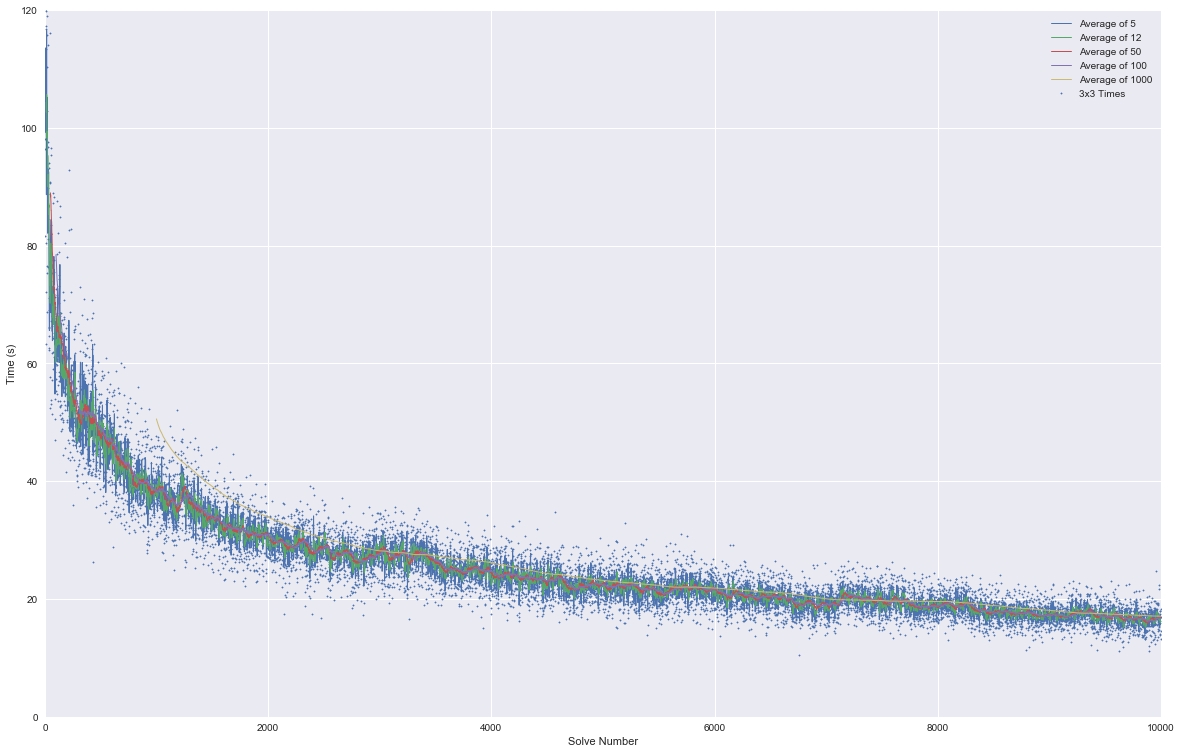

In [142]:
# plot solves
plt.scatter(range(len(rdf)),rdf['Time'], label='3x3 Times', s=2)
plt.plot(range(len(rdf)),rdf.ao5, label='Average of 5', linewidth=1)
plt.plot(range(len(rdf)),rdf.ao12, label='Average of 12', linewidth=1)
plt.plot(range(len(rdf)),rdf.ao50, label='Average of 50', linewidth=1)
plt.plot(range(len(rdf)),rdf.ao100, label='Average of 100', linewidth=1)
plt.plot(range(len(rdf)),rdf.ao1000, label='Average of 1000', linewidth=1)
# plt.xlim(len(rdf)-6000,len(rdf))
plt.xlim(0, len(rdf))
plt.ylim(0,120)
plt.ylabel('Time (s)')
plt.xlabel('Solve Number')
plt.legend(loc='best')

In [ ]:
tms = rdf['Time'].values
step = 0.25
maxt = 50
n_per_step = 40 # decrease for cleaner animation

fig, ax = plt.subplots()

bins = np.arange(0,maxt+step,step)
frequencies = np.zeros(len(bins)-1)
rects = ax.bar(bins[:-1], frequencies, 0.25)

plt.xlim(0, maxt)
plt.ylim(0, np.max(np.histogram(tms, bins)[0])+25)
plt.xlabel('Solve time (s)')
plt.ylabel('Count')

def animate(arg, rects):
    frameno, frequencies = arg
    for rect, f in zip(rects, frequencies):
        rect.set_height(f)

interval = int(10*n_per_step/len(tms)*1e3)

def step():
    frequencies = np.zeros(len(bins)-1)
    for frame in np.arange(1, len(tms)//n_per_step+3):
        frequencies += np.histogram(tms[(frame-1)*n_per_step:frame*n_per_step], bins)[0]
        yield frame, frequencies

        

ani = animation.FuncAnimation(fig, animate, step, 
                        interval=interval, repeat=False, 
                              blit=False, fargs=(rects,), save_count=len(tms)//n_per_step+3)
ani.save('cubehist.mp4') 

In [148]:
ani

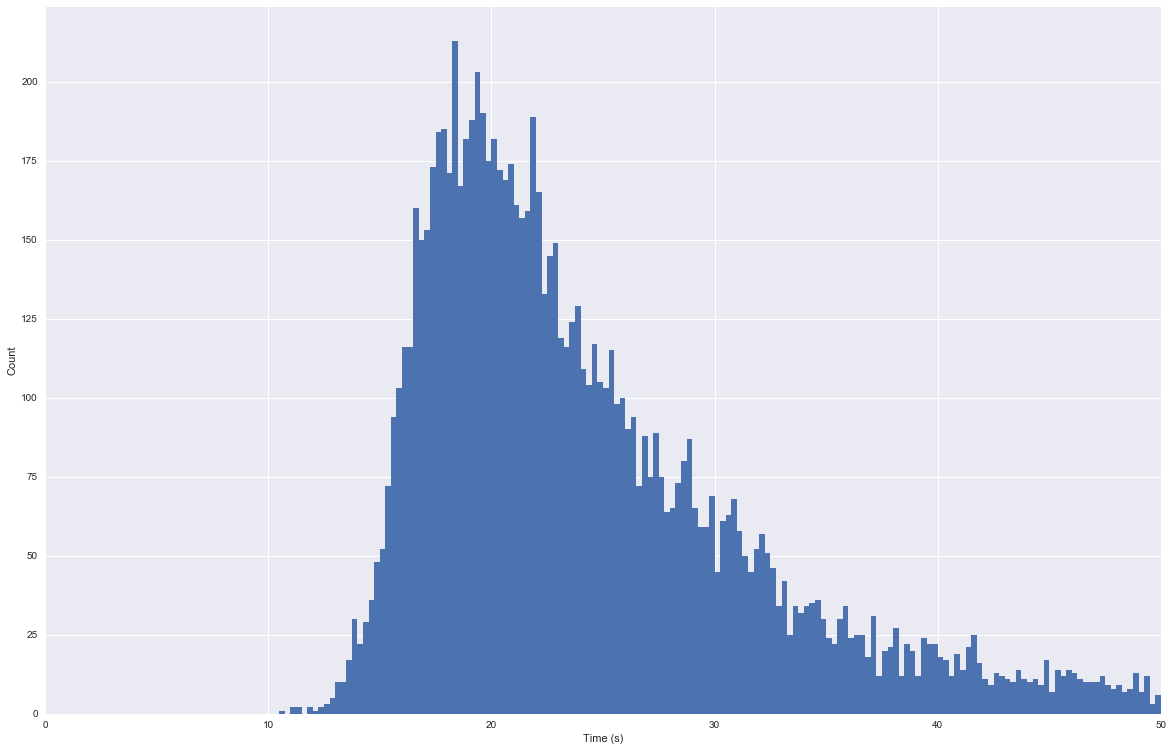

In [128]:
# Histogram of times.  Set range and step to what you want
tms = rdf['Time'].values
step = 0.25
maxt = 50
bins = np.arange(0,maxt+step,step)
plt.hist(tms, bins=bins)
plt.xlim(0,maxt)
plt.xlabel('Time (s)')
plt.ylabel('Count')

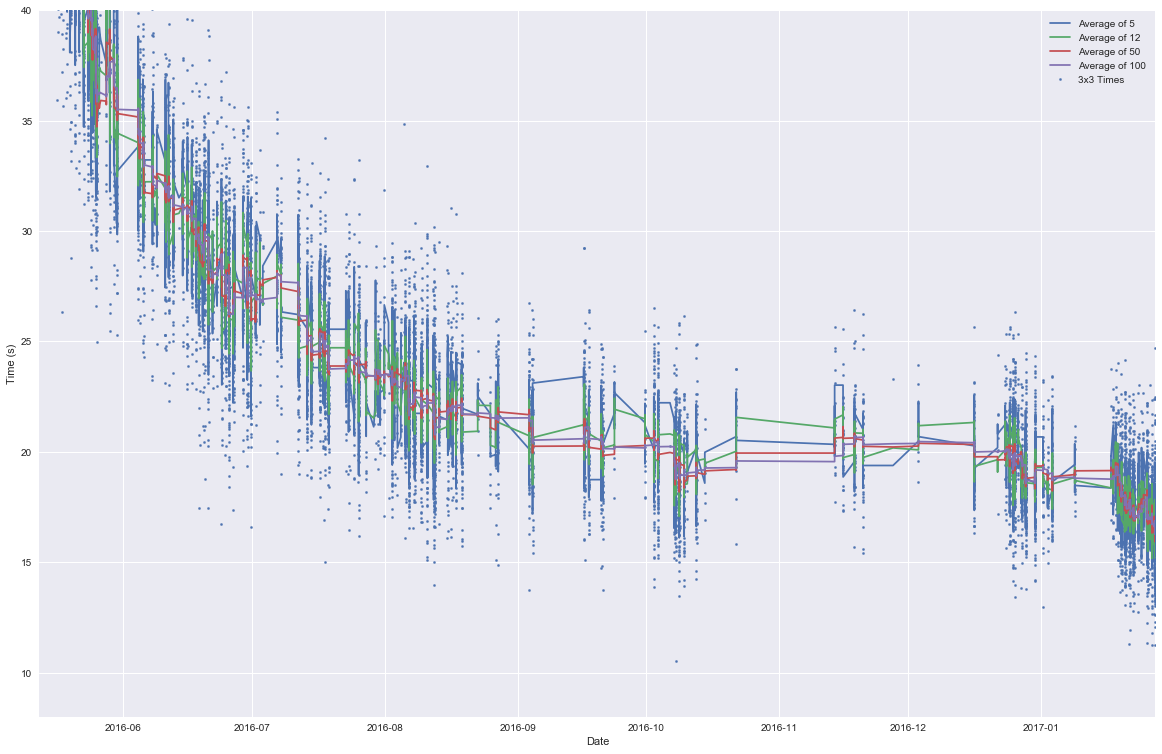

In [138]:
# Plot times vs date.  Set the y range and x range to desired values
plt.scatter(rdf.index,rdf['Time'], label='3x3 Times',s=5)
plt.plot(rdf.ao5, label='Average of 5')
plt.plot(rdf.ao12, label='Average of 12')
plt.plot(rdf.ao50, label='Average of 50')
plt.plot(rdf.ao100, label='Average of 100')
plt.xlim(rdf.index[0],rdf.index[-1]) # x range
plt.ylim(8,40) # y range
plt.ylabel('Time (s)')
plt.xlabel('Date')
plt.legend(loc='best')

In [24]:
# show pbs
print('single: %.3f    '%min(rdf['Time'].dropna()))
print('mo3: %.3f    '%min(rdf.mo3.dropna()))
print('ao5: %.3f    '%min(rdf.ao5.dropna()))
print('ao12: %.3f    '%min(rdf.ao12.dropna()))
print('ao50: %.3f    '%min(rdf.ao50.dropna()))
print('ao100: %.3f    '%min(rdf.ao100.dropna()))
print('ao1000: %.3f    '%min(rdf.ao1000.dropna()))

single: 10.520    
mo3: 13.663    
ao5: 14.167    
ao12: 15.170    
ao50: 15.934    
ao100: 16.274    
ao1000: 17.084    


In [146]:
# show pbs before point
last = 1000
print('single: %.3f → %.3f    ' % (min(rdf['Time'][:-last].dropna()), min(rdf['Time'].dropna())))
print('mo3: %.3f → %.3f    ' % (min(rdf.mo3[:-last].dropna()), min(rdf.mo3.dropna())))
print('ao5: %.3f → %.3f    ' % (min(rdf.ao5[:-last].dropna()), min(rdf.ao5.dropna())))
print('ao12: %.3f → %.3f    ' % (min(rdf.ao12[:-last].dropna()), min(rdf.ao12.dropna())))
print('ao50: %.3f → %.3f    ' % (min(rdf.ao50[:-last].dropna()), min(rdf.ao50.dropna())))
print('ao100: %.3f → %.3f    ' % (min(rdf.ao100[:-last].dropna()), min(rdf.ao100.dropna())))
print('ao1000: %.3f → %.3f    ' % (min(rdf.ao1000[:-last].dropna()), min(rdf.ao1000.dropna())))

single: 10.520 → 10.520    
mo3: 14.823 → 13.663    
ao5: 15.593 → 14.167    
ao12: 16.366 → 15.170    
ao50: 17.022 → 15.934    
ao100: 17.066 → 16.274    
ao1000: 18.076 → 17.084    


In [29]:
# count number of solves per day
date_range = pd.date_range(min(df['Date']).date(), max(df['Date']).date())
cdf = pd.DataFrame(index=date_range)
cdf['Count'] = 0
for row in rdf.iterrows():
    cdf.ix[row[1].name.date()] +=1

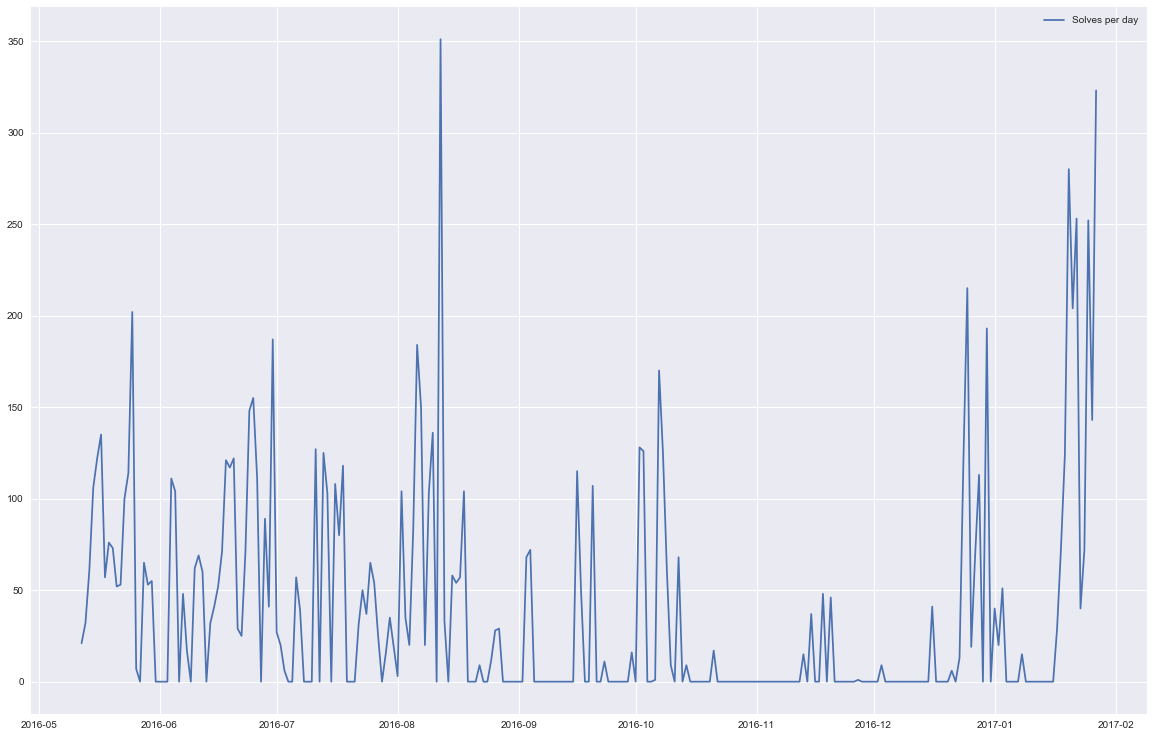

In [30]:
# plot number of solves per day
plt.plot(cdf, label='Solves per day')
plt.legend(loc='best')

In [31]:
# PB Progression calculation
pb = [rdf['Time'][0]]
mo3pb = [rdf.mo3[2]]
ao5pb = [rdf.ao5[4]]
ao12pb = [rdf.ao12[11]]
ao50pb = [rdf.ao50[49]]
ao100pb = [rdf.ao100[99]]
xpb = [[rdf.index[0],1]]
xmo3pb = [[rdf.index[2],3]]
xao5pb = [[rdf.index[4],5]]
xao12pb = [[rdf.index[11],12]]
xao50pb = [[rdf.index[49],50]]
xao100pb = [[rdf.index[99],100]]

i = 0
for row in rdf.iterrows():
    i+=1
    if row[1].Time<pb[-1]:
        pb.append(row[1].Time)
        xpb.append([row[1].name, i])
    if i>2 and row[1].mo3<mo3pb[-1]:
        mo3pb.append(row[1].mo3)
        xmo3pb.append([row[1].name, i])
    if i>4 and row[1].ao5<ao5pb[-1]:
        ao5pb.append(row[1].ao5)
        xao5pb.append([row[1].name, i])
    if i>11 and row[1].ao12<ao12pb[-1]:
        ao12pb.append(row[1].ao12)
        xao12pb.append([row[1].name, i])
    if i>49 and row[1].ao50<ao50pb[-1]:
        ao50pb.append(row[1].ao50)
        xao50pb.append([row[1].name, i])
    if i>99 and row[1].ao100<ao100pb[-1]:
        ao100pb.append(row[1].ao100)
        xao100pb.append([row[1].name, i])    

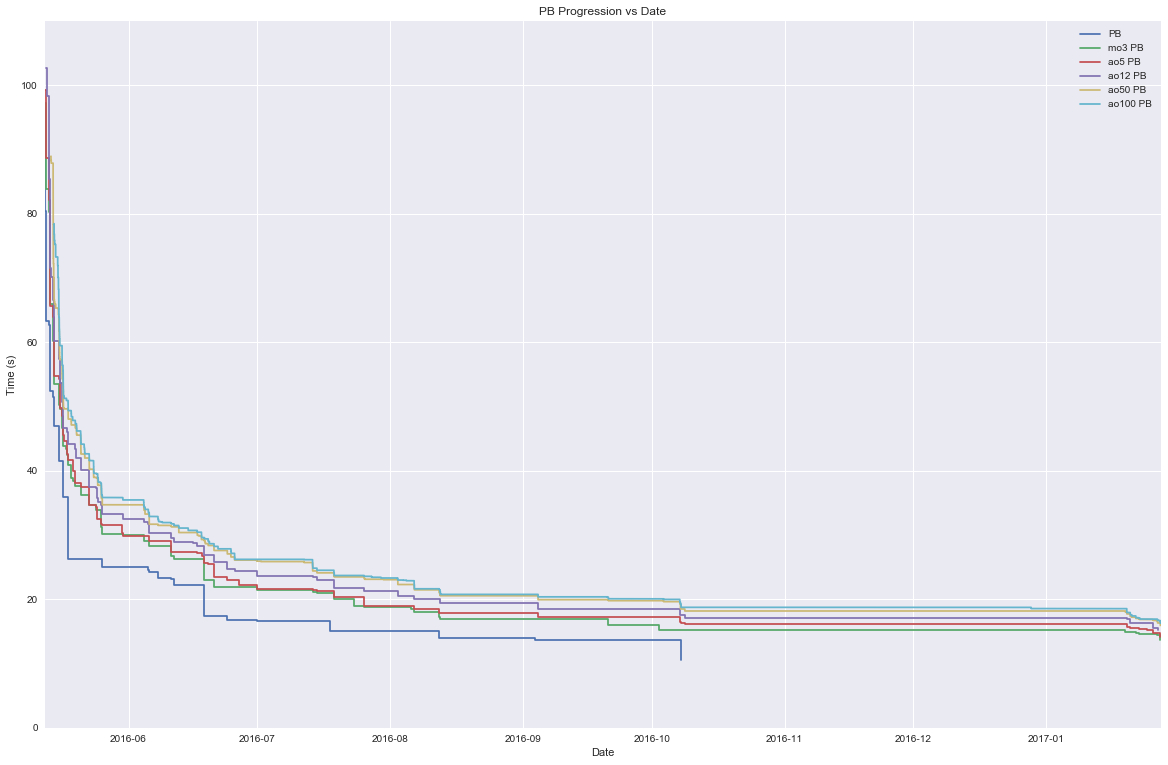

In [144]:
# plot pb progression vs date
xs = [xpb, xmo3pb,xao5pb,xao12pb,xao50pb,xao100pb]
ys = [pb, mo3pb,ao5pb,ao12pb,ao50pb,ao100pb]
labels = ['PB', 'mo3 PB', 'ao5 PB', 'ao12 PB', 'ao50 PB', 'ao100 PB']

for i in range(len(labels)):
    plt.step([j[0] for j in xs[i]], ys[i], label=labels[i], where='post')
plt.xlim(rdf.index[0],rdf.index[-1])
plt.legend(loc='best')
plt.ylim([0,110])
plt.title('PB Progression vs Date')
plt.xlabel('Date')
plt.ylabel('Time (s)')

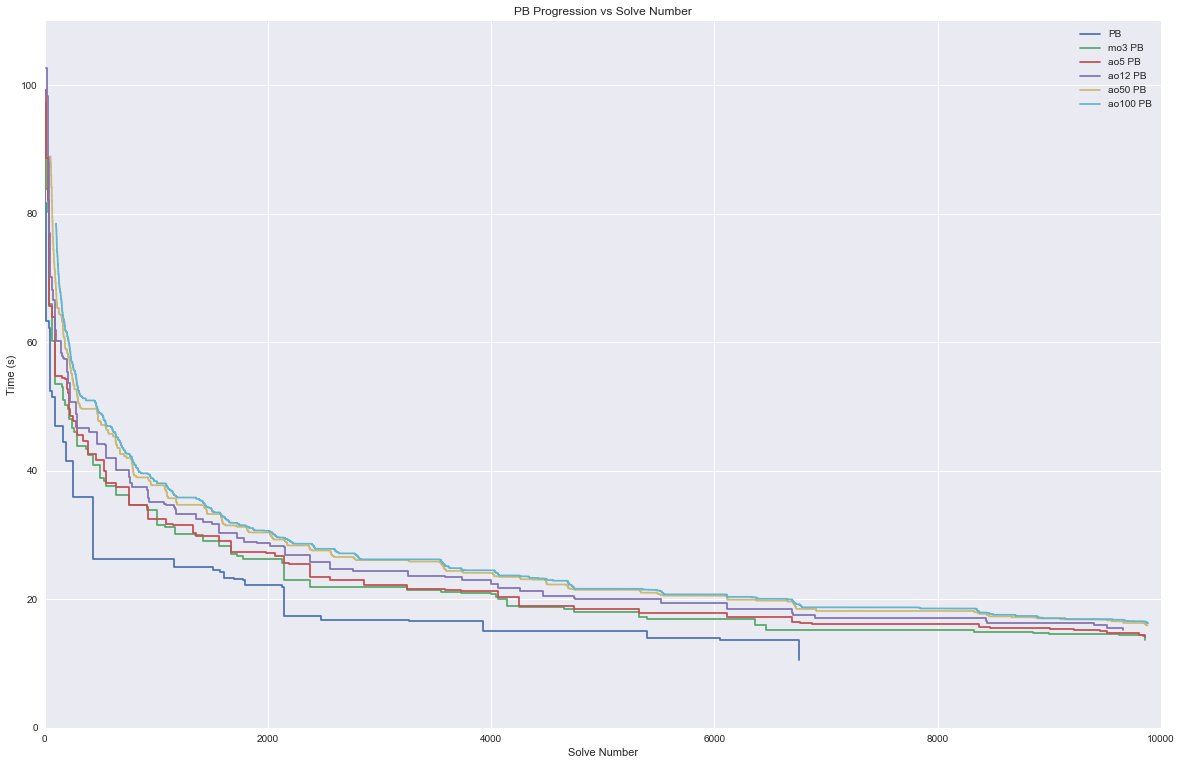

In [145]:
# plot pb progression vs solve num
xs = [xpb, xmo3pb,xao5pb,xao12pb,xao50pb,xao100pb]
ys = [pb, mo3pb,ao5pb,ao12pb,ao50pb,ao100pb]
labels = ['PB', 'mo3 PB', 'ao5 PB', 'ao12 PB', 'ao50 PB', 'ao100 PB']

for i in range(len(labels)):
    plt.step([j[1] for j in xs[i]], ys[i], label=labels[i], where='post')
# plt.xlim(rdf.index[1500],rdf.index[-1])
plt.legend(loc='best')
plt.xlim(0,len(rdf))
plt.ylim([0,110])
plt.title('PB Progression vs Solve Number')
plt.xlabel('Solve Number')
plt.ylabel('Time (s)')

In [6]:
# nothing fancy, just basic cstimer times import
fn = 'cstimer.txt'
with open(fn) as f:
    data = json.load(f)
times = []
scrambles = []
for sessionname in data.keys():
    if sessionname!='properties':
        j1 = json.loads(data[sessionname])
        for solve in j1:
            times.append(solve[0][1]/1000.0)
            scrambles.append(solve[1])

In [24]:
def cstimerimport(filename):
    with open(filename) as f:
        data = json.load(f)
    times = []
    scrambles = []
    for sessionname in data.keys():
        if sessionname!='properties':
            j1 = json.loads(data[sessionname])
            for solve in j1:
                times.append(solve[0][1]/1000.0)
                scrambles.append(solve[1])

# This should be changed to the method used above
def listtodf(timelist):
    rdf = pd.DataFrame(timelist, columns=['Time'])
    for i in range(len(rdf['Time'])):
        if i<2:
            pass
        if i>=2:
            rdf.set_value(rdf.index[i], 'mo3', round(sum(rdf['Time'][i-2:i+1])/3.0,3))
        if i>=4:
            tmp=rdf['Time'][i-4:i+1]
            rdf.set_value(rdf.index[i], 'ao5', round(sum(tmp.sort_values()[1:-1])/3.0,3))
            rdf.set_value(rdf.index[i], 'sd5', round(np.std(tmp),3))
        if i>=11:
            tmp=rdf['Time'][i-11:i+1]
            rdf.set_value(rdf.index[i], 'ao12', round(sum(tmp.sort_values()[1:-1])/10.0,3))
            rdf.set_value(rdf.index[i], 'sd12', round(np.std(tmp),3))
        if i>=49:
            tmp = rdf['Time'][i-49:i+1]
            rdf.set_value(rdf.index[i], 'ao50', round(sum(tmp.sort_values()[3:-3])/44.0,3))
            rdf.set_value(rdf.index[i], 'sd50', round(np.std(tmp),3))

        if i>=99:
            tmp = rdf['Time'][i-99:i+1]
            rdf.set_value(rdf.index[i], 'ao100', round(sum(tmp.sort_values()[5:-5])/90.0,3))
            rdf.set_value(rdf.index[i], 'sd100', round(np.std(tmp),3))

        if i>=999:
            tmp = rdf['Time'][i-999:i+1]
            rdf.set_value(rdf.index[i], 'ao1000', round(sum(tmp.sort_values()[50:-50])/900.0,3))
            rdf.set_value(rdf.index[i], 'sd1000', round(np.std(tmp),3))
    return rdf

In [42]:
dates = (np.array(rdf.index).astype(np.int64)/1e9).astype(np.int64)
solves = (np.array(rdf.Time)*1000).astype(np.int64)
full = np.append(dates, solves).reshape(2,-1).T
np.savetxt('times.csv', full, delimiter=',')